In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
def dataGeneration(m,n):  
    """Generating data from {-1,1}. Labels are generated from the first column of the X values dataset.

    Args:
      m : number of samples
      n : number of dimensions

    Returns:
      X : dataset of values, shape = m*n
      y : dataset of labels, shape = m*1

    """   
    X = 2 * np.random.multinomial(1,pvals=[0.5,0.5],size = m * n).argmax(axis=1) - 1
    X = np.array(X).reshape((m,n))
    y = X[:,0]
    
    return X,y

## Perceptron algorithm implementation

In [3]:
# perceptron implementation
def perceptron(X_train,X_test,y_train,y_test, threshold=0.001):
    """Perceptron classification algorithm.

    Args:
      X_train (vector): array of training points
      X_test (vector): array of testing datapoints
      y_train (vector): array of training labels
      y_test (vector): array of testing labels
      threshold (scalr) : training error value at which the algorithm is deemed "converged"

    Returns:
      mistake/len(y_test) (scalar): misclassification error on the test set

    """   
    m,n = X_train.shape
    weights = np.zeros(n) #adding a bias term
    mistakes = 1 # arbitrary value to enter while loop
    
    #training model
    while mistakes > threshold:
        mistakes = 0
        for idx, xval in enumerate(X_train):
            # Insering 1 for bias, X0 = 1.
            y_hat = 1.0 if ((np.dot(xval, weights)) > 0) else -1.0
            #print(y[idx], y_hat)
            if ((y_hat) - float(y_train[idx])) != 0:
                weights += y_train[idx]*xval
                mistakes += 1
        mistakes = mistakes/m
    
    #testing model
    test_mistake = 0
    y_pred = 2 * (np.matmul(X_test, weights) > 0) - 1
    
    return np.count_nonzero(y_pred - y_test)/len(y_test)

## Winnow algorithm implementation

In [4]:
def winnow(X_train,X_test,y_train,y_test, threshold=0.001):
    """Winnow classification algorithm.

    Args:
      X_train (vector): array of training points
      X_test (vector): array of testing datapoints
      y_train (vector): array of training labels
      y_test (vector): array of testing labels
      threshold (scalr) : training error value at which the algorithm is deemed "converged"

    Returns:
      mistake/len(y_test) (scalar): misclassification error on the test set

    """   
    #modifying data to have 0s and 1s
    X_train = np.clip(X_train, 0,2)
    y_train = np.clip(y_train, 0,2)
    X_test = np.clip(X_test, 0,2)
    y_test = np.clip(y_test, 0,2)
    #print(X_train,y_train,X_test, y_test)
    m,n = X_train.shape
    
    mistakes = 1 # arbitrary value to enter while loop
    weights = np.ones(n) #adding a bias term
    
    # training the model
    while mistakes > threshold:
        mistakes = 0
        for idx, xval in enumerate(X_train):
            # Calculating prediction/hypothesis.Using unit step function to predict 0 and 1 instead of floats
            y_hat = (np.dot(weights,xval) >= n)
            if y_hat != y_train[idx]:
                weights *= 2**((float(y_train[idx]) - y_hat)*xval)
                mistakes += 1
        mistakes = mistakes/m
    
    #testing model
    test_mistake = 0
    
    y_pred = (np.matmul(X_test, weights) >= n)
    
    return np.count_nonzero(y_pred - y_test)/len(y_test)


## Least squares classification implementation

In [5]:
def least_squares(X_train,X_test,y_train,y_test):
    """Least squares classification implementation.

    Args:
      X_train (vector): array of training points
      X_test (vector): array of testing datapoints
      y_train (vector): array of training labels
      y_test (vector): array of testing labels

    Returns:
      mistake/len(y_test) (scalar): misclassification error on the test set

    """
    m,n = X_train.shape
    mistake = 0
    #training a least squares model
    theta = np.linalg.pinv(X_train) @ y_train
    
    # testing model
    for idx, xval in enumerate(X_test):
        # check if point is above or below the line        
        y_hat = -1.0 if (np.dot(xval, theta.T) < 0) else 1.0        
        if (np.squeeze(y_hat) - y_test[idx]) != 0: # if mistake
            mistake += 1
        
    return mistake/len(y_test)

## KNN implementation (used with k=1)

In [6]:
def get_neighbor(all_points, current_point):
    """Computes the k-nearest neighbors for a given point

    Args:
      all_points (2D vector): training datapoints
      current_point (2D vector): testing point
      k (scalar): number of neighbors to consider when classifying

    Returns:
      neighbors (array): array of k-nearest neighbors

    """
    # get distance from all training points. square root is not implemented 
    # in order to speed up computation time (will not effect rank of distances)
    dist_squared = np.sum((current_point - all_points)**2, axis=-1) 
    # get indices of the k nearest neighbors
    kidx = np.argsort(dist_squared)[0] 
    return kidx

def knn(X_train,X_test,y_train,y_test):
    
    """KNN running function.
    
    Calculates a K-Nearest Neighbors classification on a previously built
    KNN model.

    Args:
      X_train (vector) : array of training points
      X_test (vector) : array of testing datapoints
      y_train (vector) : array of training labels
      y_test (vector) : array of testing labels
      S_test (vector) : size of the testing set
      k (scalar) : number of nerest neighbors to consider


    Returns:
      accuracy (scalar): accuracy of the prediction
      class_prediction (1D array): array of updated labels
    """
    S_test= len(y_test)
    class_prediction = np.zeros(S_test)
    for i in range(S_test):
        #get neighbors
        idx = get_neighbor(X_train, X_test[i])
        #print(X_train.shape,y_train.shape)
        # save class information of single nearest neighbor
        #print(idx, y_train[idx], y_train)
        class_prediction[i] = y_train[idx]

    return class_prediction

def one_nn(X_train,X_test,y_train,y_test):
    """1nn run function.
    
    Args:
      X_train (vector) : array of training points
      X_test (vector) : array of testing datapoints
      y_train (vector) : array of training labels
      y_test (vector) : array of testing labels
      S_test (vector) : size of the testing set
      


    Returns:
      generalization error (scalar): mse
    """
    
    #modifying data to have 0s and 1s
    X_train = np.clip(X_train, 0,2)
    y_train = np.clip(y_train, 0,2)
    X_test = np.clip(X_test, 0,2)
    y_test = np.clip(y_test, 0,2)
    
    y_hat = knn(X_train,X_test,y_train,y_test)
    return np.mean((y_hat != y_test)**2)
    

In [7]:
def getSampleComplexity_MonteCarlo(n_max,m_max,algo, iterations):
    """Sample Complexity function using Monte Carlo sampling. Samples are generated independently over 
    multiple iterations. Errors are average aover the total amount of iterations.
    
    Args:
      n_max (int) : maximum dimension value
      m_max (int) : maximum training set size value
      algo (function) : given algorithm to test on
      iterations (int) : nb of iterations to run for a given m

    Returns:
      range(1,n_max + 1) (list) : list of all dimensions tested
      min_m (list) : list of optimal m values (value at which the algorithm can guarantee a gen
      error of less than 0.1)
    """
    sample_size = list(range(1, m_max))
    min_m = np.zeros(n_max)
    err = np.zeros(iterations)
    for n in range(1,n_max + 1):
        print('working with' ,n,'dimensions')
        for m in sample_size:
            error = 0
            for _ in range(iterations):
                #generate training inputs 
                X_train,y_train = dataGeneration(m,n)

                #generate test inputs (test size is equal to current dimension, n)
                X_test,y_test = dataGeneration(n,n)

                error += algo(X_train,X_test,y_train,y_test)

            error = error/iterations
            #check whether this is less than 0.1
            if error <= 0.1:
                print('error is',error, 'for an m of', m)
                min_m[n - 1] = m
                break
            
    return range(1,n_max + 1), min_m

def getSampleComplexity_CumulError(n_max,m_max,algo,iterations):
    """Sample Complexity function using cumulative summed error method. In order to calculate the error
    we sum over all past error values (for every m we have already tested).  This error is dependent to 
    every value of m.
    
    Args:
      n_max (int) : maximum dimension value
      m_max (int) : maximum training set size value
      algo (function) : given algorithm to test on
      iterations (int) : nb of iterations to run for a given m
      
    Returns:
      range(1,n_max + 1) (list) : list of all dimensions tested
      min_m (list) : list of optimal m values (value at which the algorithm can guarantee a gen
      error of less than 0.1)
    """
    min_m = np.zeros(n_max)
    err = np.zeros(iterations)
    for n in range(1,n_max + 1):
        print('working with' ,n,'dimensions')
        m = 1   
        while True:
            current_m = m
            error = 0
            for _ in range(current_m):
                for _ in range(iterations):
                    #generate training inputs 
                    X_train,y_train = dataGeneration(m,n)

                    #generate test inputs (test size is equal to current dimension, n)
                    X_test,y_test = dataGeneration(n,n)

                    error += algo(X_train,X_test,y_train,y_test)

            error = error/(current_m*iterations)
            #check whether this is less than 0.1
            if error <= 0.1:
                print('error is',error, 'for an m of', m)
                min_m[n - 1] = m
                break
            m += 1
            
    return range(1,n_max + 1), min_m

def complexityPlot(m,n,algo_name):
    'plots the sample complexity of a given algorithm'
    
    fig = plt.figure()
    plt.plot(m,n)
    plt.xlabel('n')
    plt.ylabel('m')
    plt.savefig("%s_samplecomplexity.png"%str(algo_name))
    
    return plt.show

### Estimating sample complexity for the Perceptron algorithm

working with 1 dimensions
error is 0.0 for an m of 1
working with 2 dimensions
error is 0.1 for an m of 5
working with 3 dimensions
error is 0.0 for an m of 1
working with 4 dimensions
error is 0.07142857142857142 for an m of 7
working with 5 dimensions
error is 0.06666666666666667 for an m of 3
working with 6 dimensions
error is 0.06666666666666667 for an m of 5
working with 7 dimensions
error is 0.031746031746031744 for an m of 9
working with 8 dimensions
error is 0.075 for an m of 10
working with 9 dimensions
error is 0.06837606837606837 for an m of 13
working with 10 dimensions
error is 0.09090909090909091 for an m of 11
working with 11 dimensions
error is 0.0984848484848485 for an m of 12
working with 12 dimensions
error is 0.06818181818181818 for an m of 11
working with 13 dimensions
error is 0.08974358974358976 for an m of 12
working with 14 dimensions
error is 0.05442176870748298 for an m of 21
working with 15 dimensions
error is 0.06984126984126984 for an m of 21
working with 

<function matplotlib.pyplot.show(close=None, block=None)>

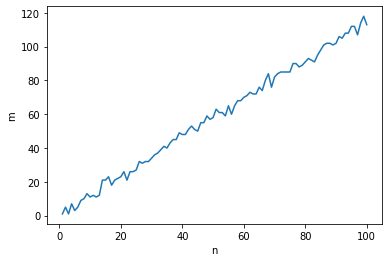

In [36]:
startTime = time.perf_counter()
perpectron_dim, perceptron_min_m = getSampleComplexity_CumulError(n_max=100,m_max=1000, algo = perceptron, iterations =1)
print("Sample complexity took: {0:.2f}s".format(time.perf_counter() - startTime))
complexityPlot(perpectron_dim, perceptron_min_m, perceptron)

### Estimating sample complexity for the Winnow algorithm

working with 1 dimensions
error is 0.0 for an m of 1
working with 2 dimensions
error is 0.0 for an m of 2
working with 3 dimensions
error is 0.09523809523809523 for an m of 7
working with 4 dimensions
error is 0.08333333333333333 for an m of 6
working with 5 dimensions
error is 0.1 for an m of 2
working with 6 dimensions
error is 0.09259259259259259 for an m of 9
working with 7 dimensions
error is 0.03571428571428571 for an m of 8
working with 8 dimensions
error is 0.075 for an m of 10
working with 9 dimensions
error is 0.07407407407407407 for an m of 9
working with 10 dimensions
error is 0.07777777777777778 for an m of 9
working with 11 dimensions
error is 0.06611570247933884 for an m of 11
working with 12 dimensions
error is 0.08333333333333331 for an m of 9
working with 13 dimensions
error is 0.09340659340659341 for an m of 14
working with 14 dimensions
error is 0.05357142857142857 for an m of 12
working with 15 dimensions
error is 0.0787878787878788 for an m of 11
working with 16 d

error is 0.09745762711864406 for an m of 20
working with 119 dimensions
error is 0.0955329500221141 for an m of 19
working with 120 dimensions
error is 0.06 for an m of 20
working with 121 dimensions
error is 0.08146399055489965 for an m of 21
working with 122 dimensions
error is 0.08968177434908389 for an m of 17
working with 123 dimensions
error is 0.08091366627951993 for an m of 21
working with 124 dimensions
error is 0.06578947368421051 for an m of 19
working with 125 dimensions
error is 0.07963636363636364 for an m of 22
working with 126 dimensions
error is 0.05253212396069537 for an m of 21
working with 127 dimensions
error is 0.09031959240389069 for an m of 17
working with 128 dimensions
error is 0.08251953125 for an m of 16
working with 129 dimensions
error is 0.09873521011831905 for an m of 19
working with 130 dimensions
error is 0.07230769230769232 for an m of 20
working with 131 dimensions
error is 0.08396946564885496 for an m of 20
working with 132 dimensions
error is 0.088

error is 0.09504643962848285 for an m of 19
working with 86 dimensions
error is 0.07995570321151714 for an m of 21
working with 87 dimensions
error is 0.08347016967706626 for an m of 21
working with 88 dimensions
error is 0.09210227272727271 for an m of 20
working with 89 dimensions
error is 0.09235955056179769 for an m of 20
working with 90 dimensions
error is 0.09251461988304083 for an m of 19
working with 91 dimensions
error is 0.08717948717948705 for an m of 21
working with 92 dimensions
error is 0.09043478260869559 for an m of 20
working with 93 dimensions
error is 0.0833077316948286 for an m of 21
working with 94 dimensions
error is 0.0934650455927051 for an m of 21
working with 95 dimensions
error is 0.09403508771929822 for an m of 21
working with 96 dimensions
error is 0.08697916666666668 for an m of 20
working with 97 dimensions
error is 0.09479626902307296 for an m of 21
working with 98 dimensions
error is 0.09860365198711066 for an m of 19
working with 99 dimensions
error is

<function matplotlib.pyplot.show(close=None, block=None)>

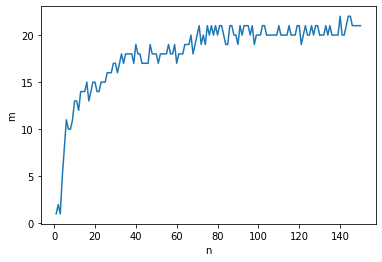

In [9]:
# 1 iterations
startTime = time.perf_counter()
winnow_dimit, winnow_min_mit = getSampleComplexity_CumulError(n_max=150,m_max=1000, algo = winnow,iterations=1)
print("Sample complexity took: {0:.2f}s".format(time.perf_counter() - startTime))

# 10 iterations (for plotting purposes below)
startTime = time.perf_counter()
winnow_dim, winnow_min_m = getSampleComplexity_CumulError(n_max=150,m_max=1000, algo = winnow,iterations=10)
print("Sample complexity took: {0:.2f}s".format(time.perf_counter() - startTime))
complexityPlot(winnow_dim, winnow_min_m, winnow)

### Estimating sample complexity for the Least-squares classification algorithm

working with 1 dimensions
error is 0.0 for an m of 1
working with 2 dimensions
error is 0.0 for an m of 2
working with 3 dimensions
error is 0.0 for an m of 2
working with 4 dimensions
error is 0.0 for an m of 3
working with 5 dimensions
error is 0.0 for an m of 1
working with 6 dimensions
error is 0.0 for an m of 6
working with 7 dimensions
error is 0.08571428571428572 for an m of 5
working with 8 dimensions
error is 0.0625 for an m of 4
working with 9 dimensions
error is 0.09523809523809523 for an m of 7
working with 10 dimensions
error is 0.09999999999999999 for an m of 7
working with 11 dimensions
error is 0.06818181818181818 for an m of 8
working with 12 dimensions
error is 0.06481481481481481 for an m of 9
working with 13 dimensions
error is 0.08547008547008547 for an m of 9
working with 14 dimensions
error is 0.07142857142857142 for an m of 10
working with 15 dimensions
error is 0.09333333333333332 for an m of 10
working with 16 dimensions
error is 0.09090909090909091 for an m o

<function matplotlib.pyplot.show(close=None, block=None)>

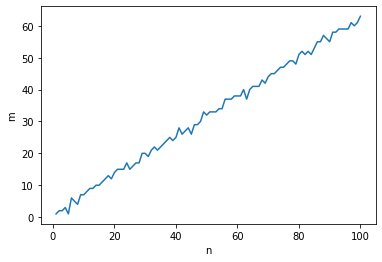

In [10]:
startTime = time.perf_counter()
ls_dim, ls_min_m = getSampleComplexity_CumulError(n_max=100,m_max=1000, algo = least_squares, iterations = 1)
print("Sample complexity took: {0:.2f}s".format(time.perf_counter() - startTime))
complexityPlot(ls_dim, ls_min_m, least_squares)

### Estimating sample complexity for the 1-nn classification algorithm

working with 1 dimensions
error is 0.0 for an m of 2
working with 2 dimensions
error is 0.0 for an m of 4
working with 3 dimensions
error is 0.09523809523809523 for an m of 7
working with 4 dimensions
error is 0.0 for an m of 4
working with 5 dimensions
error is 0.08421052631578947 for an m of 19
working with 6 dimensions
error is 0.08333333333333333 for an m of 12
working with 7 dimensions
error is 0.059523809523809514 for an m of 12
working with 8 dimensions
error is 0.09693877551020408 for an m of 49
working with 9 dimensions
error is 0.09722222222222211 for an m of 104
working with 10 dimensions
error is 0.09243697478991587 for an m of 119
working with 11 dimensions
error is 0.09780267126238701 for an m of 211
working with 12 dimensions
error is 0.0985632183908045 for an m of 290
working with 13 dimensions
error is 0.09750566893424042 for an m of 441
working with 14 dimensions
error is 0.09993496639930631 for an m of 659
working with 15 dimensions
error is 0.098566978193147 for an 

<function matplotlib.pyplot.show(close=None, block=None)>

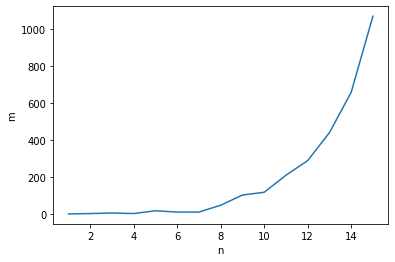

In [11]:
startTime = time.perf_counter()
knn_dim, knn_min_m = getSampleComplexity_CumulError(n_max=15,m_max=3000, algo = one_nn, iterations = 1)
print("Sample complexity took: {0:.2f}s".format(time.perf_counter() - startTime))
complexityPlot(knn_dim, knn_min_m, one_nn)

## Testing Monte Carlo Sampling

### Winnow on  Monte Carlo

In [32]:
# 1 iteration
startTime = time.perf_counter()
w_MC_n_it, w_MC_m_it = getSampleComplexity_MonteCarlo(n_max=150,m_max=1000, algo = winnow, iterations = 20)
print("Sample complexity took: {0:.2f}s".format(time.perf_counter() - startTime))

#10 iterations
startTime = time.perf_counter()
w_MC_n, w_MC_m = getSampleComplexity_MonteCarlo(n_max=150,m_max=1000, algo = winnow, iterations = 30)
print("Sample complexity took: {0:.2f}s".format(time.perf_counter() - startTime))

working with 1 dimensions
error is 0.0 for an m of 1
working with 2 dimensions
error is 0.05 for an m of 3
working with 3 dimensions
error is 0.05 for an m of 7
working with 4 dimensions
error is 0.0375 for an m of 8
working with 5 dimensions
error is 0.08 for an m of 6
working with 6 dimensions
error is 0.08333333333333333 for an m of 8
working with 7 dimensions
error is 0.02857142857142857 for an m of 12
working with 8 dimensions
error is 0.06875 for an m of 10
working with 9 dimensions
error is 0.08888888888888888 for an m of 9
working with 10 dimensions
error is 0.1 for an m of 9
working with 11 dimensions
error is 0.0909090909090909 for an m of 8
working with 12 dimensions
error is 0.09583333333333334 for an m of 13
working with 13 dimensions
error is 0.07307692307692307 for an m of 14
working with 14 dimensions
error is 0.0964285714285714 for an m of 11
working with 15 dimensions
error is 0.08333333333333333 for an m of 11
working with 16 dimensions
error is 0.05 for an m of 13
w

error is 0.09008264462809916 for an m of 18
working with 122 dimensions
error is 0.04057377049180329 for an m of 20
working with 123 dimensions
error is 0.08780487804878048 for an m of 20
working with 124 dimensions
error is 0.08870967741935483 for an m of 19
working with 125 dimensions
error is 0.09040000000000001 for an m of 20
working with 126 dimensions
error is 0.06746031746031744 for an m of 20
working with 127 dimensions
error is 0.0826771653543307 for an m of 20
working with 128 dimensions
error is 0.094921875 for an m of 21
working with 129 dimensions
error is 0.06279069767441861 for an m of 23
working with 130 dimensions
error is 0.059615384615384605 for an m of 21
working with 131 dimensions
error is 0.08053435114503815 for an m of 20
working with 132 dimensions
error is 0.07878787878787877 for an m of 20
working with 133 dimensions
error is 0.09962406015037592 for an m of 17
working with 134 dimensions
error is 0.0962686567164179 for an m of 18
working with 135 dimensions
e

error is 0.0943181818181818 for an m of 21
working with 89 dimensions
error is 0.07902621722846442 for an m of 19
working with 90 dimensions
error is 0.0774074074074074 for an m of 21
working with 91 dimensions
error is 0.07472527472527472 for an m of 19
working with 92 dimensions
error is 0.05543478260869565 for an m of 22
working with 93 dimensions
error is 0.09749103942652328 for an m of 20
working with 94 dimensions
error is 0.0978723404255319 for an m of 20
working with 95 dimensions
error is 0.07684210526315788 for an m of 19
working with 96 dimensions
error is 0.08958333333333333 for an m of 19
working with 97 dimensions
error is 0.09037800687285222 for an m of 20
working with 98 dimensions
error is 0.09353741496598639 for an m of 19
working with 99 dimensions
error is 0.09191919191919191 for an m of 19
working with 100 dimensions
error is 0.07666666666666666 for an m of 19
working with 101 dimensions
error is 0.09636963696369638 for an m of 20
working with 102 dimensions
error 

### Perceptron on Monte Carlo

In [24]:
startTime = time.perf_counter()
p_MC_n, p_MC_m = getSampleComplexity_MonteCarlo(n_max=100,m_max=1000, algo = perceptron, iterations = 30)
print("Sample complexity took: {0:.2f}s".format(time.perf_counter() - startTime))

working with 1 dimensions
error is 0.06666666666666667 for an m of 3
working with 2 dimensions
error is 0.06666666666666667 for an m of 5
working with 3 dimensions
error is 0.08888888888888888 for an m of 5
working with 4 dimensions
error is 0.05 for an m of 8
working with 5 dimensions
error is 0.07333333333333332 for an m of 7
working with 6 dimensions
error is 0.03888888888888888 for an m of 12
working with 7 dimensions
error is 0.09999999999999996 for an m of 7
working with 8 dimensions
error is 0.1 for an m of 9
working with 9 dimensions
error is 0.09629629629629632 for an m of 13
working with 10 dimensions
error is 0.07333333333333335 for an m of 13
working with 11 dimensions
error is 0.0818181818181818 for an m of 13
working with 12 dimensions
error is 0.09722222222222224 for an m of 15
working with 13 dimensions
error is 0.0923076923076923 for an m of 17
working with 14 dimensions
error is 0.09999999999999999 for an m of 16
working with 15 dimensions
error is 0.08888888888888889

### LS on  Monte Carlo

In [20]:
startTime = time.perf_counter()
ls_MC_n, ls_MC_m = getSampleComplexity_MonteCarlo(n_max=100,m_max=1000, algo = least_squares, iterations = 30)
print("Sample complexity took: {0:.2f}s".format(time.perf_counter() - startTime))

working with 1 dimensions
error is 0.0 for an m of 1
working with 2 dimensions
error is 0.0 for an m of 2
working with 3 dimensions
error is 0.09999999999999999 for an m of 4
working with 4 dimensions
error is 0.025 for an m of 5
working with 5 dimensions
error is 0.06 for an m of 5
working with 6 dimensions
error is 0.049999999999999996 for an m of 5
working with 7 dimensions
error is 0.05714285714285714 for an m of 5
working with 8 dimensions
error is 0.1 for an m of 6
working with 9 dimensions
error is 0.07777777777777777 for an m of 7
working with 10 dimensions
error is 0.085 for an m of 7
working with 11 dimensions
error is 0.07272727272727272 for an m of 8
working with 12 dimensions
error is 0.07916666666666666 for an m of 8
working with 13 dimensions
error is 0.053846153846153856 for an m of 9
working with 14 dimensions
error is 0.09285714285714283 for an m of 10
working with 15 dimensions
error is 0.06 for an m of 11
working with 16 dimensions
error is 0.078125 for an m of 11
w

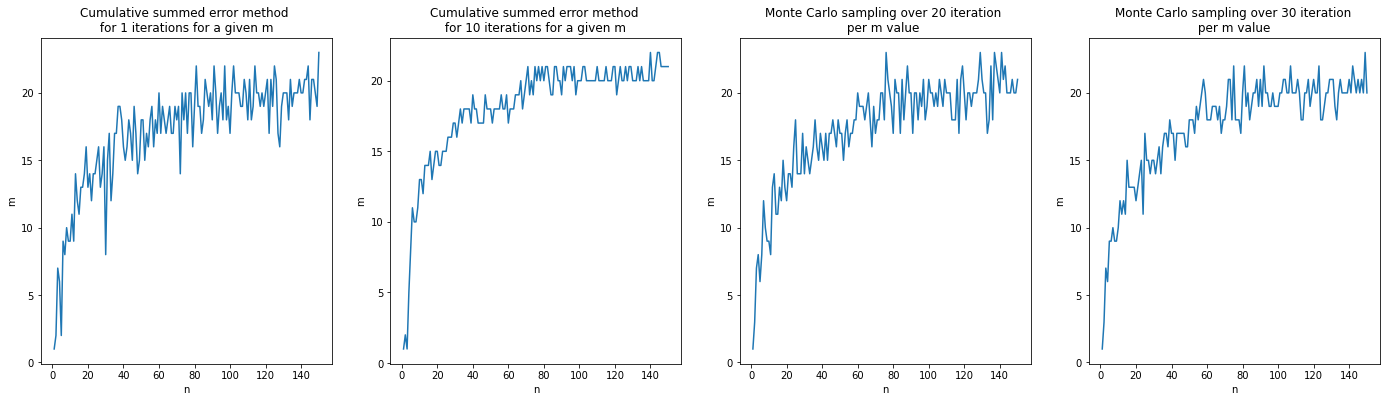

In [37]:
# visualising different error calculations on the winnow algorithm
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(24, 6))
ax[0].title.set_text('Cumulative summed error method \n for 1 iterations for a given m ')
ax[0].plot(winnow_dimit, winnow_min_mit)
ax[0].set_xlabel('n')
ax[0].set_ylabel('m')
ax[1].title.set_text('Cumulative summed error method \n for 10 iterations for a given m ')
ax[1].plot(winnow_dim, winnow_min_m)
ax[1].set_xlabel('n')
ax[1].set_ylabel('m')
ax[2].title.set_text('Monte Carlo sampling over 20 iteration \n per m value  ')
ax[2].plot(w_MC_n_it, w_MC_m_it)
ax[2].set_xlabel('n')
ax[2].set_ylabel('m')
ax[3].title.set_text('Monte Carlo sampling over 30 iteration \n per m value ')
ax[3].plot(w_MC_n, w_MC_m)
ax[3].set_xlabel('n')
ax[3].set_ylabel('m')
fig.savefig('testing_out_error.png')

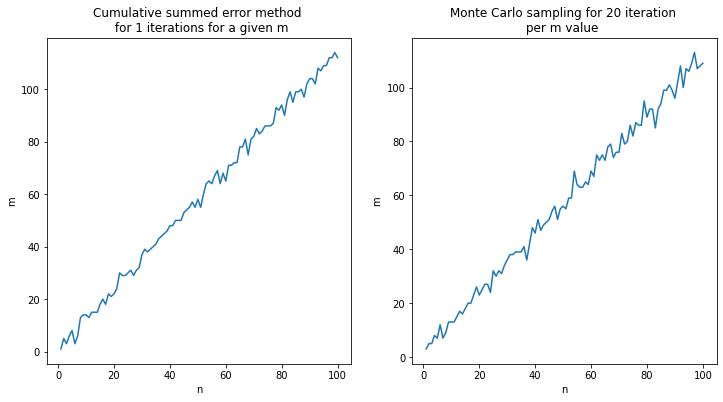

In [34]:
# visualising different error calculations on the perceptron algorithm
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
ax[0].title.set_text('Cumulative summed error method \n for 1 iterations for a given m')
ax[0].plot(perpectron_dim, perceptron_min_m)
ax[0].set_xlabel('n')
ax[0].set_ylabel('m')
ax[1].title.set_text('Monte Carlo sampling for 30 iteration \n per m value  ')
ax[1].plot(p_MC_n, p_MC_m)
ax[1].set_xlabel('n')
ax[1].set_ylabel('m')
fig.savefig('pcomp.png')

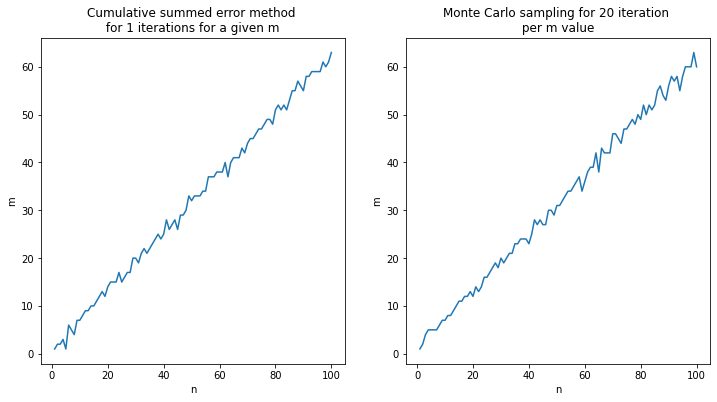

In [35]:
# visualising different error calculations on the perceptron algorithm
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
ax[0].title.set_text('Cumulative summed error method \n for 1 iterations for a given m ')
ax[0].plot(ls_dim, ls_min_m)
ax[0].set_xlabel('n')
ax[0].set_ylabel('m')
ax[1].title.set_text('Monte Carlo sampling for 30 iteration \n per m value ')
ax[1].plot(ls_MC_n, ls_MC_m)
ax[1].set_xlabel('n')
ax[1].set_ylabel('m')
fig.savefig('lscomp.png')